<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/TestODECoupling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


In [0]:
from fenics import *
import numpy as np


def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est


def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new

  
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t*t*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u0 = interpolate(u_D, V)


# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

def f(t):
  return(3*beta*t*t - 2 - 2*alpha)

J = assemble(dot(grad(u), grad(v))*dx)
M = assemble(u*v*dx)
b = assemble(v*dx)

theta = 0.5;

def single_step(theta, t, tp, dt, u):
  u_D.t = t;
  f.t = t;
  Al=1/dt*M + theta*J;
  Ar=1/dt*M -(1-theta)*J;
  rhs = Ar*u.vector() + (theta*f(t) + (1-theta)*f(tp))*b;
  bc.apply(Al, rhs)
  u=Function(V)
  solve(Al, u.vector(), rhs)
  return u

u = Function(V)

tp = 0;
t = 0;
tol = 1e-8;

while t<T:
  u_low  = single_step(theta, t,              tp,            dt,     u0)
  u_mid  = single_step(theta, 0.5*(t + tp),   tp,            dt/2,   u0)
  u_high = single_step(theta, t,              0.5*(t + tp), dt/2,   u_mid)
    
  est = compute_est(theta, u_low, u_high)
  dt_new = compute_new_dt(theta, est, tol, dt)
  print(est, dt_new, t)
  
  if est > tol:
      dt = dt_new
      continue
      
  tp = t;
  t += dt
  dt = dt_new
  u0.vector()[:] = u_high.vector()[:]

1.329539607363974e-15 520.3560527034123 0
2.438266971488376e-07 99.97265763912927 0.2
1.2685723793951007e-06 8.420635457627629 0.2
1.4965374929229117e-05 0.20650107665785414 0.2
0.0003447451465557213 0.0010551021176183751 0.2
5.48898673149184e-05 1.3510445158426693e-05 0.2
9.54179917716169e-07 1.312126714533626e-06 0.2
9.308552960778455e-08 4.079960377053118e-07 0.2
2.8953899303669077e-08 2.2746976047279398e-07 0.2
1.6143722599413403e-08 1.6984121258450506e-07 0.2
1.2054031632696235e-08 1.467567796024324e-07 0.2
1.0415763597029639e-08 1.3641868871818492e-07 0.2
9.682075587875477e-09 1.3152578150658405e-07 0.2
2.645287406806103e-16 0.0007671772460820307 0.20000013641868872
2.3850293845405484e-06 4.7127033286555706e-05 0.20000026794447023
9.718792680170787e-10 0.00014341190241458327 0.20000026794447023
2.388231399454389e-08 8.80376111409991e-05 0.20004739497775678
5.7808906631276794e-09 0.00010984799305293203 0.20004739497775678
1.0099583891903122e-08 0.00010369591327607696 0.20013543258

Task 2, theta = 1
t          | dt         | energy    
    0.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e3c780>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e3c780>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bb3b70>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bb3b70>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.2000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e83e10>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e83e10>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d39c579b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d39c579b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.3000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34de7da0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34de7da0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.4000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c319e8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c319e8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d348f5630>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d348f5630>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346f72b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346f72b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.7000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fc37390>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fc37390>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.8000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e3c208>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e3c208>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34d17400>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34d17400>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34b33048>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34b33048>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ace908>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ace908>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.2000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.3000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ace198>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ace198>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d39c77400>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d39c77400>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.4000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d39c7f080>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d39c7f080>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.5000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e7b4a8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e7b4a8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.6000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34d9c080>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34d9c080>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.7000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349dbbe0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349dbbe0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.8000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d344a0710>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d344a0710>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.9000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Task 2, theta = 0.5
t          | dt         | energy    
    0.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38838b00>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38838b00>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d388a3780>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d388a3780>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38fcbef0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38fcbef0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e287f0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e287f0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.3000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34b26588>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34b26588>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.4000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346751d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346751d0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d342b8dd8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d342b8dd8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.7000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34294358>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34294358>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bcc0b8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bcc0b8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.8000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fc52ef0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fc52ef0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a3c4a8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a3c4a8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38faddd8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38faddd8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.2000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a893c8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a893c8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fbbc9b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fbbc9b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.3000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c57710>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c57710>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.4000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34be1940>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34be1940>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.5000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34889438>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34889438>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.6000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.7000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ca83c8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ca83c8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d385cedd8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d385cedd8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.8000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34b6bc50>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34b6bc50>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.9000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dbf080>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dbf080>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Task 2, theta = 0
t          | dt         | energy    
    0.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347ecc50>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347ecc50>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bae668>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bae668>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3498a9e8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3498a9e8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.3000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.4000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fc526d8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3fc526d8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3856fdd8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3856fdd8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34088358>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34088358>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6000 |     0.1000 |     0.5293


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38816908>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38816908>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.7000 |     0.1000 |     -60.00


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34d1e550>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34d1e550>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.8000 |     0.1000 |  6.881e+05


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34554160>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34554160>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9000 |     0.1000 |  9.899e+08


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fa3d30>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fa3d30>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0000 |     0.1000 |  4.123e+11


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.1000 |     0.1000 | -1.407e+14


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3452cb38>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3452cb38>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dbf8d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dbf8d0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.2000 |     0.1000 |  3.805e+19


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38f8f588>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38f8f588>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.3000 |     0.1000 |  1.659e+23


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e12780>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e12780>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.4000 |     0.1000 | -4.981e+26


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d340b6438>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d340b6438>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.5000 |     0.1000 |  1.486e+29


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d342b4ef0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d342b4ef0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.6000 |     0.1000 | -2.718e+33


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34637c50>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34637c50>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.7000 |     0.1000 |  3.074e+36


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.8000 |     0.1000 |  1.591e+40


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347a0be0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347a0be0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3811b9e8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3811b9e8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.9000 |     0.1000 |  5.610e+43


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33f9deb8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33f9deb8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Task 3, theta = 1
t          | dt         | energy    
    0.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c40550>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c40550>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1000 |     0.1000 |     0.6000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346612b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346612b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2000 |     0.1000 |     0.7000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bb6048>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bb6048>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.3000 |     0.1000 |     0.8000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.4000 |     0.1000 |     0.9000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341ff630>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341ff630>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349eb240>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349eb240>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5000 |     0.1000 |      1.000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341e50f0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341e50f0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6000 |     0.1000 |      1.100


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d342b8518>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d342b8518>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.7000 |     0.1000 |      1.200


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3490c080>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3490c080>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.8000 |     0.1000 |      1.300


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34005048>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34005048>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9000 |     0.1000 |      1.400


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33f63208>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33f63208>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0000 |     0.1000 |      1.500


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fe4da0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fe4da0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1000 |     0.1000 |      1.600


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3429ac18>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3429ac18>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.2000 |     0.1000 |      1.700


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3468d748>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3468d748>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.3000 |     0.1000 |      1.800


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341d9208>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341d9208>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.4000 |     0.1000 |      1.900


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33d5abe0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33d5abe0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.5000 |     0.1000 |      2.000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b5d710>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b5d710>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.6000 |     0.1000 |      2.100


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.7000 |     0.1000 |      2.200


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33d64780>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33d64780>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33eb5ac8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33eb5ac8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.8000 |     0.1000 |      2.300


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33d4cbe0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33d4cbe0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.9000 |     0.1000 |      2.400


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bf92b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bf92b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Task 4, theta = 1
t          | dt         | energy    
    0.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33a0b630>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33a0b630>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1000 |     0.1000 |     0.7000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346072b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346072b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2000 |     0.1000 |     0.9000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.3000 |     0.1000 |      1.100


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341258d0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d341258d0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a46cc0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a46cc0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.4000 |     0.1000 |      1.300


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349085c0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349085c0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5000 |     0.1000 |      1.500


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33bfd6d8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33bfd6d8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6000 |     0.1000 |      1.700


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34948320>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34948320>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.7000 |     0.1000 |      1.900


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33e74f28>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33e74f28>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.8000 |     0.1000 |      2.100


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cbab70>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cbab70>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9000 |     0.1000 |      2.300


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338ff7b8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338ff7b8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0000 |     0.1000 |      2.500


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d337052b0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d337052b0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1000 |     0.1000 |      2.700


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.2000 |     0.1000 |      2.900


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33726518>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33726518>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ef6668>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ef6668>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.3000 |     0.1000 |      3.100


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d386da630>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d386da630>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.4000 |     0.1000 |      3.300


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34178ba8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34178ba8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.5000 |     0.1000 |      3.500


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a5d7f0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a5d7f0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.6000 |     0.1000 |      3.700


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ffc400>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ffc400>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.7000 |     0.1000 |      3.900


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3414f048>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3414f048>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.8000 |     0.1000 |      4.100


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d337f9c50>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d337f9c50>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.9000 |     0.1000 |      4.300


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Task 5, theta = 1
t          | dt         | energy    
    0.0000 |     0.1000 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33afd470>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33afd470>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38848da0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38848da0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1000 |     0.1000 |     0.5450


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b819e8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b819e8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2000 |     0.1000 |     0.5850


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dfe6d8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dfe6d8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.3000 |     0.1000 |     0.6200


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ba8320>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34ba8320>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.4000 |     0.1000 |     0.6500


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34529f28>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34529f28>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5000 |     0.1000 |     0.6750


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33e27b70>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33e27b70>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6000 |     0.1000 |     0.6950


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ab67b8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ab67b8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.7000 |     0.1000 |     0.7100


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.8000 |     0.1000 |     0.7200


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cfbef0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cfbef0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3862d5c0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3862d5c0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dc77f0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dc77f0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a34470>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a34470>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b1a278>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b1a278>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.2000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33c0b160>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33c0b160>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.3000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.4000 |     0.1000 |     0.7250


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338b2278>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338b2278>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d391f66a0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d391f66a0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.5000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338e3ba8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338e3ba8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.6000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3487d898>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3487d898>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.7000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d336a4e48>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d336a4e48>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.8000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d340c3cf8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d340c3cf8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.9000 |     0.1000 |     0.7250


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Task 6, theta = 1
t          | dt         | energy    
    0.0000 |     1.0000 |     0.5000
    0.0000 |     0.0071 |     0.5000
    0.0000 |     0.0031 |     0.5000
    0.0000 |     0.0025 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fdbac8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fdbac8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38558fd0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38558fd0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0025 |     0.0024 |     0.5012


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347a04e0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347a04e0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0049 |     0.0050 |     0.5024


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a4f240>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34a4f240>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0099 |     0.0061 |     0.5049


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.0160 |     0.0090 |     0.5079


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338b94a8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338b94a8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.0250 |     0.0113 |     0.5123


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33c64710>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33c64710>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cb1828>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cb1828>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0362 |     0.0132 |     0.5177


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33236a90>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33236a90>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0494 |     0.0141 |     0.5240


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.0635 |     0.0156 |     0.5306


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3382d470>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3382d470>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.0791 |     0.0167 |     0.5378


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bddcc0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bddcc0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38fd8b00>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38fd8b00>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0958 |     0.0186 |     0.5453


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33caf240>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33caf240>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1144 |     0.0205 |     0.5536


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d348606d8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d348606d8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1349 |     0.0232 |     0.5624


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347ac940>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d347ac940>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1581 |     0.0265 |     0.5722


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33a29be0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33a29be0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1846 |     0.0313 |     0.5830


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.2159 |     0.0383 |     0.5953


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fbb828>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fbb828>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b81e48>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33b81e48>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2542 |     0.0501 |     0.6095


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33bd2048>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33bd2048>


    0.3042 |     0.0741 |     0.6269


DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38f1deb8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar


    0.3783 |     0.1287 |     0.6500
    0.3783 |     0.0854 |     0.6500


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38f1deb8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34004a58>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34004a58>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.4638 |     0.1210 |     0.6729
    0.4638 |     0.0745 |     0.6729


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346756a0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d346756a0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5382 |     0.1091 |     0.6901
    0.5382 |     0.0729 |     0.6901


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cce2e8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33cce2e8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6112 |     0.0977 |     0.7043
    0.6112 |     0.0746 |     0.7043


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33827ef0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33827ef0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.6858 |     0.0900 |     0.7160
    0.6858 |     0.0766 |     0.7160


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.7624 |     0.0856 |     0.7251


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3381d518>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3381d518>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349d65f8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349d65f8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.8480 |     0.0781 |     0.7316


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34cb8e48>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar


    0.9261 |     0.0831 |     0.7345


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34cb8e48>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3394a5f8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3394a5f8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0092 |     0.1111 |     0.7351


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349c76d8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349c76d8>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1203 |     0.2825 |     0.7351


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3423e940>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3423e940>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.4028 |     1.1558 |     0.7351


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


Task 6, theta = 0.5
t          | dt         | energy    
    0.0000 |     1.0000 |     0.5000
    0.0000 |     0.0876 |     0.5000
    0.0000 |     0.0228 |     0.5000
    0.0000 |     0.0097 |     0.5000
    0.0000 |     0.0057 |     0.5000
    0.0000 |     0.0040 |     0.5000
    0.0000 |     0.0032 |     0.5000
    0.0000 |     0.0028 |     0.5000
    0.0000 |     0.0025 |     0.5000


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c59208>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34c59208>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0000 |     0.0024 |     0.5000


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d330bc160>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d330bc160>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0024 |     0.0023 |     0.5012


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34530940>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34530940>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0047 |     0.0039 |     0.5024


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d345fbcc0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d345fbcc0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0086 |     0.0085 |     0.5043


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.0171 |     0.0190 |     0.5085


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349ebd30>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d349ebd30>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dbc4e0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34dbc4e0>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.0361 |     0.0332 |     0.5177


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.0693 |     0.0566 |     0.5333


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338b02e8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d338b02e8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.1260 |     0.0665 |     0.5584


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33c70d68>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33c70d68>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d32f59e10>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d32f59e10>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.1925 |     0.0751 |     0.5858


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ea9860>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ea9860>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.2676 |     0.0825 |     0.6140


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.3500 |     0.0870 |     0.6417


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38848908>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38848908>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33e58e48>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33e58e48>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.4370 |     0.0884 |     0.6671


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3394aa58>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3394aa58>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.5254 |     0.0875 |     0.6891


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.6129 |     0.0855 |     0.7070


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bc2518>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34bc2518>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.6984 |     0.0833 |     0.7208


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d335da6a0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d335da6a0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.7817 |     0.0812 |     0.7307


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33061128>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33061128>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    0.8629 |     0.0795 |     0.7371


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3305c940>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3305c940>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38fc8978>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d38fc8978>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    0.9424 |     0.0780 |     0.7402


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d340bb240>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d340bb240>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.0204 |     0.0860 |     0.7409


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e0d278>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d34e0d278>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.1064 |     0.1060 |     0.7409


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ea8c88>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33ea8c88>
DEBUG:matplotlib.colorbar:Setting pcolormesh


    1.2124 |     0.1382 |     0.7409


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.3506 |     0.1866 |     0.7409


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fbfdd8>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d33fbfdd8>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.5373 |     0.2579 |     0.7409


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3329d898>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d3329d898>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


    1.7952 |     0.3619 |     0.7409


DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d32fac7f0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f9d32fac7f0>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


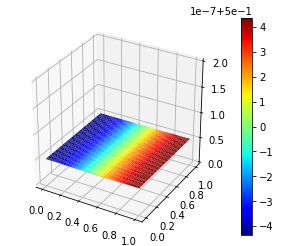

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


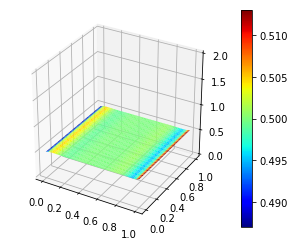

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


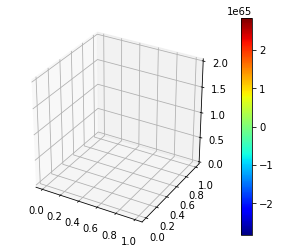

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


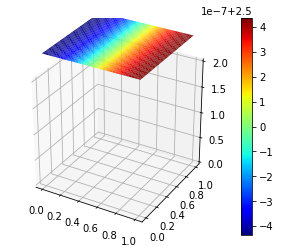

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


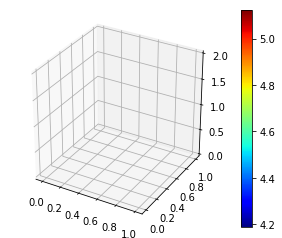

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


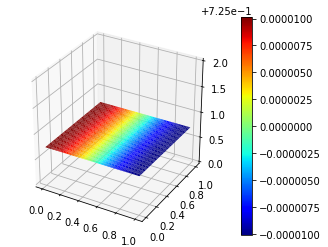

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


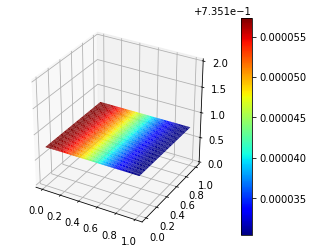

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


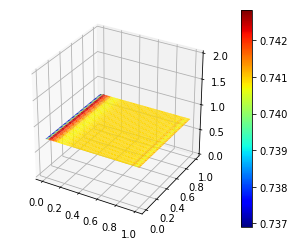

In [0]:
from dolfin import *
import matplotlib.pyplot as plt


def create_timestep_solver(get_data, dsN, theta, u_old, u_new):
    """Prepare timestep solver by theta-scheme for given
    function get_data(t) returning data (f(t), g(t)), given
    solution u_old at time t and unknown u_new at time t + dt.
    Return a solve function taking (t, dt).
    """

    # Initialize coefficients
    f_n, g_n = get_data(0)
    f_np1, g_np1 = get_data(0)
    idt = Constant(0)

    # Extract function space
    V = u_new.function_space()

    # Prepare weak formulation
    u, v = TrialFunction(V), TestFunction(V)
    theta = Constant(theta)
    F = ( idt*(u - u_old)*v*dx
        + inner(grad(theta*u + (1-theta)*u_old), grad(v))*dx
        - (theta*f_np1 + (1-theta)*f_n)*v*dx
        - (theta*g_np1 + (1-theta)*g_n)*v*dsN
    )
    a, L = lhs(F), rhs(F)

    def solve_(t, dt):
        """Update problem data to interval (t, t+dt) and
        run the solver"""

        # Update coefficients to current t, dt
        get_data(t, (f_n, g_n))
        get_data(t+dt, (f_np1, g_np1))
        idt.assign(1/dt)

        # Push log level
        old_level = get_log_level()
        warning = LogLevel.WARNING if cpp.__version__ > '2017.2.0' else WARNING
        set_log_level(warning)

        # Run the solver
        solve(a == L, u_new)

        # Pop log level
        set_log_level(old_level)

    return solve_


def timestepping(V, dsN, theta, T, dt, u_0, get_data):
    """Perform timestepping using theta-scheme with
    final time T, timestep dt, initial datum u_0 and
    function get_data(t) returning (f(t), g(t))"""

    # Initialize solution function
    u = Function(V)

    # Prepare solver for computing time step
    solver = create_timestep_solver(get_data, dsN, theta, u, u)

    # Set initial condition
    u.interpolate(u_0)

    # Open plot window
    fig = init_plot()

    # Print table header
    print("{:10s} | {:10s} | {:10s}".format("t", "dt", "energy"))

    # Perform timestepping
    t = 0
    while t < T:

        # Report some numbers
        energy = assemble(u*dx)
        print("{:10.4f} | {:10.4f} | {:#10.4g}".format(t, dt, energy))

        # Perform time step
        solver(t, dt)
        t += dt

        # Update plot
        update_plot(fig, u)


def timestepping_adaptive(V, dsN, theta, T, tol, u_0, get_data):
    """Perform adaptive timestepping using theta-scheme with
    final time T, tolerance tol, initial datum u_0 and
    function get_data(t) returning (f(t), g(t))"""

    # Initialize needed functions
    u_n = Function(V)
    u_np1_low = Function(V)
    u_np1_high = Function(V)

    # Prepare solvers for computing tentative time steps
    solver_low = create_timestep_solver(get_data, dsN, theta, u_n, u_np1_low)
    solver_high_1 = create_timestep_solver(get_data, dsN, theta, u_n, u_np1_high)
    solver_high_2 = create_timestep_solver(get_data, dsN, theta, u_np1_high, u_np1_high)

    # Initial time step; the value does not really matter
    dt = T/2

    # Set initial conditions
    u_n.interpolate(u_0)

    # Open plot window
    fig = init_plot()

    # Print table header
    print("{:10s} | {:10s} | {:10s}".format("t", "dt", "energy"))

    # Perform timestepping
    t = 0
    while t < T:

        # Report some numbers
        energy = assemble(u_n*dx)
        print("{:10.4f} | {:10.4f} | {:#10.4g}".format(t, dt, energy))

        # Compute tentative time steps
        solver_low(t, dt)
        solver_high_1(t, dt/2)
        solver_high_2(t+dt, dt/2)

        # Compute error estimate and new timestep
        est = compute_est(theta, u_np1_low, u_np1_high)
        dt_new = compute_new_dt(theta, est, tol, dt)

        if est > tol:
            # Tolerance not met; repeat the step with new timestep
            dt = dt_new
            continue

        # Move to next time step
        u_n.vector()[:] = u_np1_high.vector()
        t += dt
        dt = dt_new

        # Update plot
        update_plot(fig, u_n)


def compute_est(theta, u_L, u_H):
    """Return error estimate by Richardson extrapolation"""
    p = 2 if theta == 0.5 else 1
    est = sqrt(assemble((u_L - u_H)**2*dx)) / (2**p - 1)
    return est


def compute_new_dt(theta, est, tol, dt):
    """Return new time step"""
    p = 2 if theta == 0.5 else 1
    rho = 0.9
    dt_new = dt * ( rho * tol / est )**(1/p)
    return dt_new


def init_plot():
    """Open plot window and return its figure object"""
    fig = plt.figure()
    fig.show()
    return fig


def update_plot(fig, u, zlims=(0, 2)):
    """Plot u in 3D warp mode with colorbar into figure fig;
    use zlims as limits on z-axis"""
    fig.clear()
    p = plot(u, mode="warp")
    if p is None:
        return
    fig.colorbar(p)
    fig.gca().set_zlim(zlims)
    fig.canvas.draw()


def create_function_space():
    """Return (arbitrary) H^1 conforming function space on
    unit square domain"""
    mesh = UnitSquareMesh(32, 32)
    V = FunctionSpace(mesh, "P", 1)
    return V


def create_surface_measure_left(mesh):
    """Return surface measure on the left boundary of unit
    square"""
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0)
    facets = MeshFunction('size_t', mesh, mesh.topology().dim()-1)
    Left().mark(facets, 1)
    ds_left = Measure("ds", mesh, subdomain_data=facets, subdomain_id=1)
    return ds_left


def get_data_2(t, result=None):
    """Create or update data for Task 2"""
    f, g = result or (Constant(0), Constant(0))
    f.assign(0)
    g.assign(0)
    return f, g


def get_data_3(t, result=None):
    """Create or update data for Task 3"""
    f, g = result or (Constant(0), Constant(0))
    f.assign(1)
    g.assign(0)
    return f, g


def get_data_4(t, result=None):
    """Create or update data for Task 4"""
    f, g = result or (Constant(0), Constant(0))
    f.assign(2-t)
    g.assign(t)
    return f, g


def get_data_5(t, result=None):
    """Create or update data for Task 5 and Task 6"""
    f, g = result or (Constant(0), Constant(0))
    f.assign(0)
    g.assign(max(0, 1-t)/2)
    return f, g


if __name__ == '__main__':
    # Common data
    V = create_function_space()
    ds_left = create_surface_measure_left(V.mesh())
    T = 2
    u_0 = Expression("x[0]", degree=1)

    # Run all problems
    theta = 1
    print("Task 2, theta =", theta)
    dt = 0.1
    timestepping(V, ds_left, theta, T, dt, u_0, get_data_2)

    theta = 1/2
    print("Task 2, theta =", theta)
    dt = 0.1
    timestepping(V, ds_left, theta, T, dt, u_0, get_data_2)

    theta = 0
    print("Task 2, theta =", theta)
    dt = 0.1
    timestepping(V, ds_left, theta, T, dt, u_0, get_data_2)

    theta = 1
    print("Task 3, theta =", theta)
    dt = 0.1
    timestepping(V, ds_left, theta, T, dt, u_0, get_data_3)

    theta = 1
    print("Task 4, theta =", theta)
    dt = 0.1
    timestepping(V, ds_left, theta, T, dt, u_0, get_data_4)

    theta = 1
    print("Task 5, theta =", theta)
    dt = 0.1
    timestepping(V, ds_left, theta, T, dt, u_0, get_data_5)

    theta = 1
    print("Task 6, theta =", theta)
    tol = 1e-3
    timestepping_adaptive(V, ds_left, theta, T, tol, u_0, get_data_5)

    theta = 1/2
    print("Task 6, theta =", theta)
    tol = 1e-3
    timestepping_adaptive(V, ds_left, theta, T, tol, u_0, get_data_5)

    # Hold plots before quitting
    plt.show()
